# PREDICTING THE PREMIUM OF EUROPEAN CALL OPTIONS USING SVM AND ANN

## BACKGROUND 

Traditionally options are priced using Black Scholes Merton model. BSM is a partial differential equation derived from the assumtion that the world is risk neutral and that the price of the option is a function of underlying asset price and time. Neural networks have been used to value options since a couple of decades due to the computational efficiency which can handle the complexity of a PDE. 

## APPROACH
In this short research, I have tried to model the price of a European Call option using SVM And ANN with two layers and four layers. For SVM , I have used both Linear and RBF kernels. This is model comparison study for both the aformentioned algorithms. The evaluation metric used is RMSE. 

## DATASET 
The data set used is generated using sophisticated mathematical models. The code for data generation is in R.(refer data_generation.R file for code).  The reason for using R to generate the data is due to availability of the package 'sde' which can be used to simulate stock prices using Geometric Brownian otion discreet time model. The data set contains 5 features viz. STOCK, STRIKE, TIME , SIGMA and R. Stock is the stock price simulated using gemoetric brownian motion model with initial stock price of $100. STRIKE is the exercise price of the option, TIME is the time to maturity for that option, SIGMA is the volatility of the option and R is the risk free rate. Adhereing to the work in the paper https://arxiv.org/pdf/1901.08943.pdf, the range of values for these features are taken as follows: 

STOCK/STRIKE [0.4,1.6]
Time to maturity(TIME) [0.2,1.1]
Risk free rate (R) [0.02,0.1]
Volatility(sigma) [0.01,1.0] 

And finally the Black scholes price which is the target variable in this dataset (BS) is calculated using the user defined function of the partital differential equation in R. (refer https://www.youtube.com/watch?v=t6UslMuO-Ao&feature=youtu.be) 

60,000 instances are created using this model. 


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pltS
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

In [7]:
import os

path = os.getcwd()

print(path)
os.chdir('/Users/adheeshphadnis/Desktop')

path = os.getcwd()

/Users/adheeshphadnis


## Exploring the data 

In [8]:
mydata = pd.read_csv('options_data.csv')

In [10]:
mydata = mydata.drop('Unnamed: 0',axis = 1)
mydata.head()

,Stock,Strike,Time,sigma,r,BS
0,100.000000,94.597445,0.536456,0.218530,0.043981,10.673107
1,99.897538,90.907506,0.514215,0.511877,0.042241,19.894459
2,100.466298,88.164295,0.648659,0.253949,0.013314,15.880142
3,99.851640,51.863055,0.371761,0.448270,0.036807,48.739175
4,99.939012,46.348945,0.947809,0.558971,0.016412,55.505074


### Plotting Stock price data 

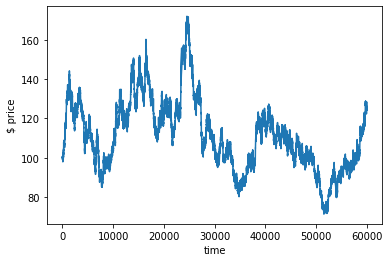

In [12]:
import matplotlib.pyplot as plt
plt.plot(mydata.index, mydata['Stock'])
plt.xlabel("time")
plt.ylabel("$ price")
plt.show()

### Correlation plot 

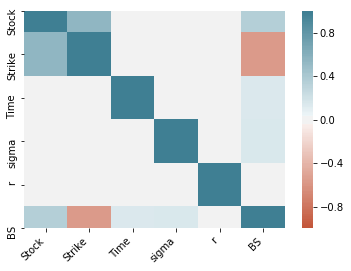

In [16]:
corr = mydata.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

All variables  have fairly strong correlation with the BS price. This is expected as the option premium is based on the features. 

# SVM with RBF kernel 

In [15]:
X = mydata.drop('BS', axis=1)
y = mydata['BS']

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=16)
print(X_train.shape)
print(y_train.shape)

(48000, 5)
(48000,)


In [89]:
import pandas as pd 
import numpy as np 
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import ShuffleSplit
import statistics

## Standardizing data 

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [19]:
X_train_std = pd.DataFrame(X_train_std, columns = X.columns)
X_train_std.head()



,Stock,Strike,Time,sigma,r
0,-0.600614,-0.104408,1.257865,-0.831835,-1.337399
1,-1.232352,-0.835981,-0.805935,-0.697150,-0.857257
2,-0.732977,0.449404,-1.395126,0.279379,-0.061074
3,0.435787,-0.483422,0.743262,-1.600505,-1.373824
4,2.970203,-0.460416,-1.308319,-0.913916,-0.280974


In [20]:
X_test_std = pd.DataFrame(X_test_std, columns = X.columns)

## Building baseline model 

In [21]:
from sklearn.svm import SVR
svm_rbf = SVR()
svm_rbf.fit(X_train_std,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [22]:
svm_rbf_preds = svm_rbf.predict(X_test_std)

In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test,svm_rbf_preds))
rms

0.5125114735936677

## Tuning using CV 

In [24]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit

bs = ShuffleSplit(n_splits=5,test_size=0.3,random_state=0)
param_grid = {'C':[0.1,1, 10, 100],'gamma': [1,0.1,0.01,0.001]}

grid1 = GridSearchCV(SVR(),param_grid,refit=True,verbose=2, cv = bs, n_jobs = -1)
grid1.fit(X_train_std,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 113.4min finished


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.3, train_size=None),
             error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [25]:
grid1.best_params_

{'C': 100, 'gamma': 0.1}

In [27]:
cv_preds = grid1.predict(X_test_std)

In [31]:
rms = sqrt(mean_squared_error(y_test,cv_preds))
rms

0.11604279967030848

### We can see that the rmse decreases significantly with CV parameters. 

In [32]:
comparison = {
    'BS' : y_test,
    'SVM RBF' : cv_preds,

}

comparison_rbf_SVR = pd.DataFrame(comparison)
comparison_rbf_SVR

,BS,SVM RBF
9066,35.716664,35.803856
478,27.568956,27.545839
26862,65.251166,65.268609
26238,48.290685,48.225181
40741,42.830820,42.918403
...,...,...
16356,32.442186,32.343963
17184,31.748947,31.637351
31655,14.577980,14.550523
14309,43.312323,43.393730


## SVM with Linear kernel 

In [59]:
svm_linear = SVR(kernel = 'linear')
svm_linear.fit(X_train_std,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [61]:
predictions_linear = svm_linear.predict(X_test_std)

In [62]:
comparison = {
    'BS' : y_test,
    'SVM Linear' : predictions_linear,

}

comparison_linear_SVR = pd.DataFrame(comparison)
comparison_linear_SVR

,BS,SVM Linear
9066,35.716664,32.906370
478,27.568956,18.893762
26862,65.251166,64.889537
26238,48.290685,47.728029
40741,42.830820,45.148999
...,...,...
16356,32.442186,30.091239
17184,31.748947,17.515701
31655,14.577980,12.329912
14309,43.312323,44.466451


In [63]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test,predictions_linear))
rms

3.287429139792727

## CV Linear kernel 

In [35]:
bs = ShuffleSplit(n_splits=5,test_size=0.3,random_state=0)
param_grid2 = {'C':[0.1,1, 10, 100]}

grid2 = GridSearchCV(SVR(kernel = 'linear'),param_grid2 ,refit=True,verbose=2, cv = bs, n_jobs = -1)
grid2.fit(X_train_std,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 48.0min finished


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.3, train_size=None),
             error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='linear',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1, param_grid={'C': [0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [36]:
grid2.best_params_

{'C': 0.1}

In [41]:
cv_preds2 = grid2.predict(X_test_std)
cv_preds2

array([32.88707483, 18.95400486, 64.85415599, ..., 12.37691935,
       44.47267414, 36.00243032])

In [38]:
rms = sqrt(mean_squared_error(y_test,cv_preds2))
rms

3.278363793764422

#### We can see that RMSE does not change significantly after CV. 

In [40]:
comparison1 = {
    'BS' : y_test,
    'SVM Linear' : cv_preds2,
    'SVM RBF': cv_preds

}

comparison_linrbf = pd.DataFrame(comparison1)
comparison_linrbf

,BS,SVM Linear,SVM RBF
9066,35.716664,32.887075,35.803856
478,27.568956,18.954005,27.545839
26862,65.251166,64.854156,65.268609
26238,48.290685,47.739650,48.225181
40741,42.830820,45.145412,42.918403
...,...,...,...
16356,32.442186,30.128535,32.343963
17184,31.748947,17.587739,31.637351
31655,14.577980,12.376919,14.550523
14309,43.312323,44.472674,43.393730


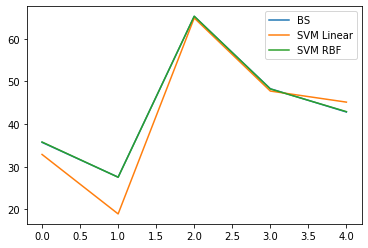

In [42]:
plt.plot(X_test_std.index[:5], comparison1['BS'][:5], label = 'BS')
plt.plot(X_test_std.index[:5],comparison1['SVM Linear'][:5], label = 'SVM Linear')
plt.plot(X_test_std.index[:5], comparison1['SVM RBF'][:5], label = 'SVM RBF')
plt.legend()
plt.show()


## Neural Net

Discussion: 

In this modeling approach, 2 layer and 4 layer deep neural networks are used. The modeling experimentation is done with different neurons in each hidden layer, batch size, epochs, dropout rate. The loss function used is RMSE. The activation function for hidden layers is 'relu'. The activation function for the output node is linear since it is a regression problem. 

In [44]:

import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.optimizers import RMSprop

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses
from sklearn.utils import shuffle

Using TensorFlow backend.


### Function for MSE

In [46]:
def mse(model):
    plt.plot(model.history['mse'])
    plt.plot(model.history['val_mse'])
    plt.title('Model mse')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()

### Function for Deep Neural Nets with2 and 4 hidden layers

In [49]:
def ann2(neurons1, neurons2,dropout,batch_size, epochs):
    model_ann2 = Sequential([
    Dense(neurons1, activation='relu', input_shape=(5,)),
    Dropout(dropout),
    Dense(neurons2, activation='relu'),
    Dropout(dropout),
    Dense(1),
    ])

    model_ann2.compile(loss='mse', optimizer='adam', metrics = ['mse'])

    hist_ann2 = model_ann2.fit(X_train_std, y_train,
            batch_size=batch_size, epochs=epochs,
            validation_data=(X_test_std, y_test), verbose = 0)

    mse(hist_ann2)
    import statistics
    print('Mean Validation Accuracy:', statistics.mean(hist_ann2.history['val_mse']))

In [77]:
def ann3(neurons1, neurons2,neurons3,neurons4,dropout,batch_size, epochs):
    model_ann2 = Sequential([
    Dense(neurons1, activation='relu', input_shape=(5,)),
    Dropout(dropout),
    Dense(neurons2, activation='relu'),
    Dropout(dropout),
    Dense(neurons3, activation='relu'),
    Dropout(dropout),
    Dense(neurons4, activation='relu'),
    Dropout(dropout),
    Dense(1),
    ])

    model_ann2.compile(loss='mse', optimizer='adam', metrics = ['mse'])

    hist_ann2 = model_ann2.fit(X_train_std, y_train,
            batch_size=batch_size, epochs=epochs,
            validation_data=(X_test_std, y_test), verbose = 0)

    mse(hist_ann2)

    print('Mean Validation Accuracy:', statistics.mean(hist_ann2.history['val_mse']))

### Sample Results of experiments 

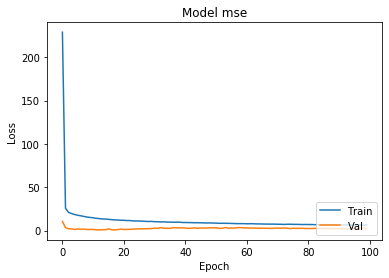

Mean Validation Accuracy: 2.3968043446540834


In [50]:
ann2(64,64,0.2,64,100)

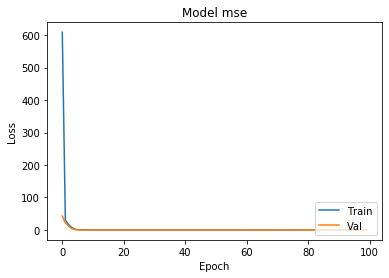

Mean Validation Accuracy: 0.8643233131291345


In [51]:
ann2(64,128,0.0,256,100)

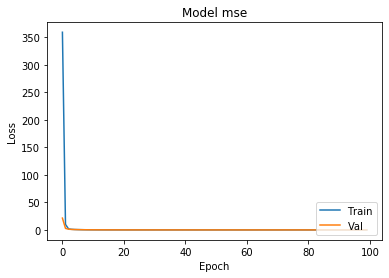

Mean Validation Accuracy: 0.3195454790396616


In [82]:
ann3(32,64,128,128,0.0,256,100)

### Interpretation 
We can see that deep neural networks with 4 hidden layers performs better than 2 layered network. After experimenting, it was found that dropout rate 0 works good. 

## FINAL MODEL 

In [83]:
model_ann2 = Sequential([
Dense(32, activation='relu', input_shape=(5,)),
Dropout(0.0),
Dense(64, activation='relu'),
Dropout(0.0),
Dense(128, activation='relu'),
Dropout(0.0),
Dense(128, activation='relu'),
Dropout(0.0),
Dense(1),
])

model_ann2.compile(loss='mse', optimizer='adam', metrics = ['mse'])

model_ann2.fit(X_train_std, y_train,
            batch_size= 256, epochs=100, verbose = 0)

ann_pred = model_ann2.predict(X_test_std)



## Extracting predictions 

In [84]:
ann_pred1 = []
for i in range(len(ann_pred)):
    a = ann_pred[i][0]
    ann_pred1.append(a)
    
ann_pred1[:5]



[35.76234, 27.668636, 65.39084, 48.43021, 42.85241]

## Tabular comparison of all models 

In [67]:
comparison2 = {
    'BS' : y_test,
    'SVM Linear' : cv_preds2,
    'SVM RBF': cv_preds,
    'ANN': ann_pred1

}

comparison = pd.DataFrame(comparison2)
comparison

,BS,SVM Linear,SVM RBF,ANN
9066,35.716664,32.887075,35.803856,35.672970
478,27.568956,18.954005,27.545839,27.734961
26862,65.251166,64.854156,65.268609,65.248695
26238,48.290685,47.739650,48.225181,48.394409
40741,42.830820,45.145412,42.918403,42.754280
...,...,...,...,...
16356,32.442186,30.128535,32.343963,32.489388
17184,31.748947,17.587739,31.637351,31.941620
31655,14.577980,12.376919,14.550523,14.521057
14309,43.312323,44.472674,43.393730,43.385460


### Graphical comparison of model predictions with BS

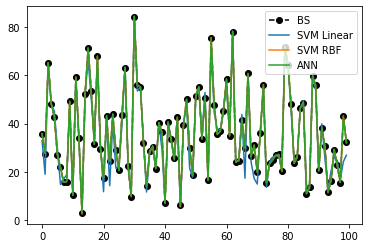

In [86]:
plt.plot(X_test_std.index[:100], comparison['BS'][:100],'ko--', label = 'BS')
plt.plot(X_test_std.index[:100],comparison['SVM Linear'][:100], label = 'SVM Linear')
plt.plot(X_test_std.index[:100], comparison['SVM RBF'][:100], label = 'SVM RBF')
plt.plot(X_test_std.index[:100], comparison['ANN'][:100], label = 'ANN')
plt.legend()
plt.show()

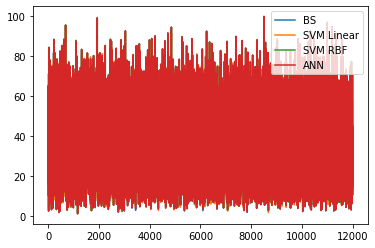

In [87]:
plt.plot(X_test_std.index, comparison['BS'], label = 'BS')
plt.plot(X_test_std.index,comparison['SVM Linear'], label = 'SVM Linear')
plt.plot(X_test_std.index, comparison['SVM RBF'], label = 'SVM RBF')
plt.plot(X_test_std.index, comparison['ANN'], label = 'ANN')
plt.legend()
plt.show()

## Prediction accuracy ranking of Algorithms 

In [94]:
algo_rank = {
    
    'SVM RBF' : 0.12 ,
    'ANN': 0.32,
    'SVM Linear': 3.29

}

algo_rank1 = pd.DataFrame(algo_rank, index = [0])
algo_rank1

,SVM RBF,ANN,SVM Linear
0,0.12,0.32,3.29


# CONCLUSION

#### After extensive modelling experiments with SVM and ANN we can see that the models predict the option premium very close to the Black Scholes model. However best results are obtained with SVM with RBF kernel. 